<a href="https://colab.research.google.com/github/juanpajedrez/pytorch_learning/blob/main/02_pytorch_classification_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book version of this notebook: https://www.learnpytorch.io/02_pytorch_classification/

I am doing my own version :) based on the video as well.

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
print(len(X))
print(len(y))

1000
1000


In [4]:
print(f"first five samples of X: {X[:5]}")
print(f"first five samples of y: {y[:5]}")

first five samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first five samples of y: [1 1 1 1 0]


In [5]:
### Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],\
                        "X2": X[:, 1], \
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
circles.value_counts("label")

,count
label,
0,500
1,500


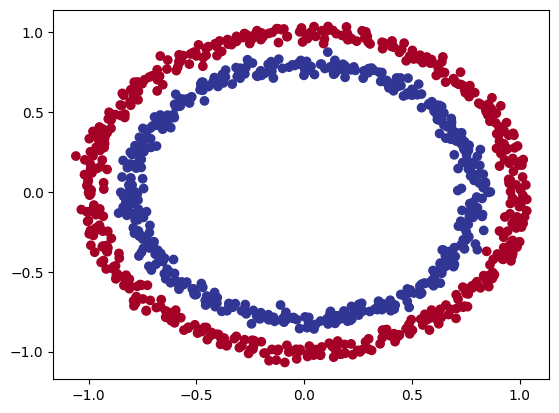

In [7]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],\
            y = X[:, 1],\
            c = y,\
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often referred to as a toy dataset, a dataset that is small enought to experiment but still sizeable to test the fundamentals.

## 1.1 Check Input and Output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Valyes for one sample of X: {X_sample}, Value for one sample of y: {y_sample}")
print(f"Sample shape of X: {X_sample.shape}, Sample shape of y: {y_sample.shape}")

Valyes for one sample of X: [0.75424625 0.23148074], Value for one sample of y: 1
Sample shape of X: (2,), Sample shape of y: ()


## 1.2 Turn data into tensors and create train and test splits


In [11]:
# Turn data into tensors
import torch
torch.__version__

'2.6.0+cu124'

In [12]:
# Turn data into tensors (from np.float64 -> torch.float32)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [15]:
torch.manual_seed(42)

In [16]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% Of data is test, 80% of data is train
                                                    random_state=42)

In [17]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [18]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our bloe and red dots

To do so, we want to:
1. Setup agnistic device code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subsclassing `nn.Module`)
3. Define a loss function and optimizer
4. Creating a training and test loop

In [19]:
# Import Pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [20]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [21]:
# Lets see a test layer nn.Linear and see their shapes to understand how it works
test_layer = nn.Linear(in_features = 2, out_features = 5)
print(test_layer)

# Lets see the weight and bias shapes
print(test_layer.weight)
print(test_layer.bias)
print(test_layer.weight.shape)
print(test_layer.bias.shape)

# SO THAT MEANS that the forward pass would be X * W^T = y to follow neural network lin alg formulation

Linear(in_features=2, out_features=5, bias=True)
Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], requires_grad=True)
Parameter containing:
tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], requires_grad=True)
torch.Size([5, 2])
torch.Size([5])


Now we've setup device agnostic code, let's create a model that:

1. Subsclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instantiate an instance of our model class and send it to our target `device`

In [22]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5) # Takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1) # Takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 _> layer_2 -> output

# 4. Instantiate ab instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
next(model_0.parameters()).device

device(type='cpu')

In [24]:
# Lets replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091]])),
             ('0.bias', tensor([ 0.4082,  0.1265,  0.3591, -0.4310, -0.7000])),
             ('1.weight',
              tensor([[-0.1728, -0.3430,  0.3670,  0.1288,  0.1852]])),
             ('1.bias', tensor([0.1414]))])

In [26]:
# Make predictions
model_0.eval()
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples : {len(X_test)}, Shape: {X_test.shape}")
print(f"\First 10 predictions:\n {untrained_preds[:10]}")
print(f"First 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples : 200, Shape: torch.Size([200, 2])
\First 10 predictions:
 tensor([[-0.1245],
        [-0.0896],
        [-0.1015],
        [-0.1315],
        [ 0.0807],
        [ 0.1006],
        [ 0.0547],
        [ 0.0997],
        [-0.1092],
        [-0.0852]])
First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [27]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function and optimizer should you use?

Again ... this is problem specific

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how wrong your model predictions are against the true labels.

And for optimizers, two of the most common are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, checkout here: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html


In [28]:
# Setup the loss function
#loss_fn = nn.BCEWithLoss() # requires inputs to have gone through the sigmoid activation function prior to BCE loss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation is built in, much better for stability.

# Setup the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [29]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 3. Train model

To train our model, we're going to build a training loop:

1. Forward pass.
2. Calculate the loss.
3. Optimizer zero_grad.
4. Loss backward (backpropagation).
5. Optimizer (gradient descent).

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g sigmoid for binary cross entropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [30]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device)[:5])
y_logits

tensor([[-0.1245],
        [-0.0896],
        [-0.1015],
        [-0.1315],
        [ 0.0807]])

In [31]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [32]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4689],
        [0.4776],
        [0.4747],
        [0.4672],
        [0.5202]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y = 1` (class 1)
* `y_pred_probs` < 0.5, `y = 0` (class 0)

In [33]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> preds probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

#Get rid of the extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 1.])

### 3.2 Building a training and testing loop

In [34]:
device

'cpu'

In [35]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [36]:
# Ensure reproducibility if possible
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build trianing and evaluation loop
for epoch in range(epochs + 1):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  #loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #               y_train)

  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as inpt
                 y_train)

  # Our own custom accuracy function
  acc = accuracy_fn(y_true = y_train,\
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step, step, step (gradient step)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_accuracy = accuracy_fn(y_true = y_test,\
                                y_pred = test_pred)
    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}| Acc: {acc:.2f}| Test Loss: {test_loss:.5f}| Test Acc: {test_accuracy:.2f}")

Epoch: 0 | Loss: 0.69451| Acc: 50.00| Test Loss: 0.69437| Test Acc: 45.50
Epoch: 10 | Loss: 0.69419| Acc: 50.38| Test Loss: 0.69434| Test Acc: 48.50
Epoch: 20 | Loss: 0.69398| Acc: 49.50| Test Loss: 0.69438| Test Acc: 51.50
Epoch: 30 | Loss: 0.69382| Acc: 49.62| Test Loss: 0.69444| Test Acc: 50.50
Epoch: 40 | Loss: 0.69369| Acc: 50.00| Test Loss: 0.69451| Test Acc: 52.50
Epoch: 50 | Loss: 0.69359| Acc: 49.62| Test Loss: 0.69458| Test Acc: 52.00
Epoch: 60 | Loss: 0.69350| Acc: 49.88| Test Loss: 0.69464| Test Acc: 50.00
Epoch: 70 | Loss: 0.69343| Acc: 50.12| Test Loss: 0.69469| Test Acc: 50.00
Epoch: 80 | Loss: 0.69337| Acc: 50.38| Test Loss: 0.69474| Test Acc: 49.00
Epoch: 90 | Loss: 0.69332| Acc: 50.00| Test Loss: 0.69478| Test Acc: 48.50
Epoch: 100 | Loss: 0.69327| Acc: 50.50| Test Loss: 0.69481| Test Acc: 48.50


### 4. Make predictions and evaluate the model

From the metrics, it looks our model is not learning anything.

So to inspect it, lets make some predictions and make them visual!

In other words, "Visualize, Visualize, Visualize".

To do so, we're going to import a function called `plot_decision_boundary()`: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py


In [37]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo (if its not already download it)
if Path("helper_functions.py").is_file():
  print("Helper functions.py already exists, skipping download")
else:
  print("Downloading helper functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

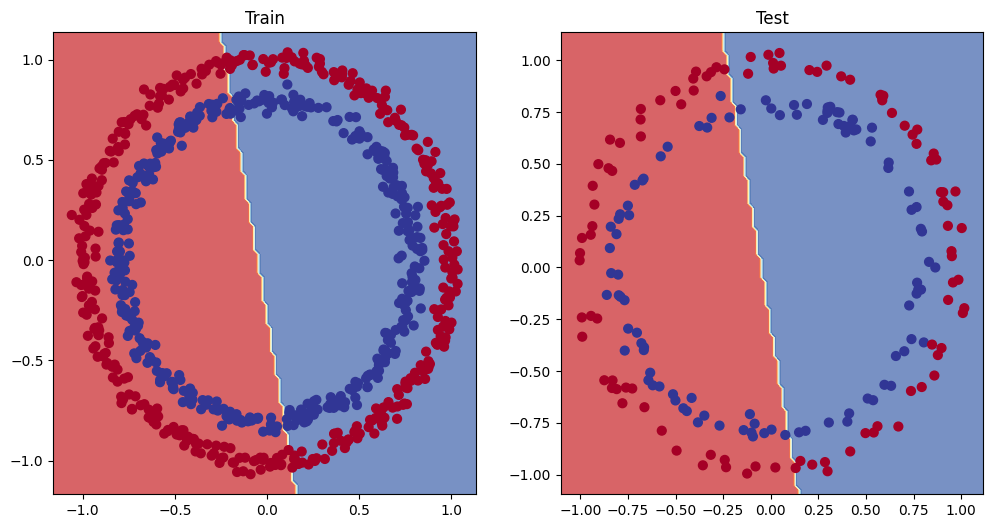

In [38]:
# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model (from a model perspective)

* **Add more layers** - give the model more chances to learn about patterns in the data.
* **Add more hidden units** - give each layer more hidden units to better represent the feature spaces. 5 -> 10
* **Fit for longer** Give the model more epochs to learn.
* **Changing the activation functions - Loss** The activation functions for loss, this only happens normally if the task loss function is not setup properly.
* **Change the optimizer** Plan to use maybe a much more intelligent optimizer.
* **Changing the learning rate** It might the the optimizer is jumping to much or is too slow.

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are reffered as **Hyperparameters**

Let's try and imporve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

**Experiment tracking warning**: ONLY change one variable at a time in real world, for now, we are doing this :)

In [39]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [40]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features = 1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [42]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [43]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Train for longer
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs+1):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true = y_train,\
                        y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step, step, step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1 Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2 Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true = y_test,\
                                y_pred = test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}| Acc: {acc:.2f}%| Test Loss: {test_loss:.5f}| Test Acc: {test_accuracy:.2f}")

Epoch: 0 | Loss: 0.69396| Acc: 50.50%| Test Loss: 0.69261| Test Acc: 51.00
Epoch: 100 | Loss: 0.69305| Acc: 50.50%| Test Loss: 0.69379| Test Acc: 48.00
Epoch: 200 | Loss: 0.69299| Acc: 50.50%| Test Loss: 0.69437| Test Acc: 46.00
Epoch: 300 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69458| Test Acc: 45.00
Epoch: 400 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69465| Test Acc: 46.00
Epoch: 500 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69467| Test Acc: 46.00
Epoch: 600 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69468| Test Acc: 46.00
Epoch: 700 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69468| Test Acc: 46.00
Epoch: 800 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69468| Test Acc: 46.00
Epoch: 900 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69468| Test Acc: 46.00
Epoch: 1000 | Loss: 0.69298| Acc: 50.50%| Test Loss: 0.69468| Test Acc: 46.00


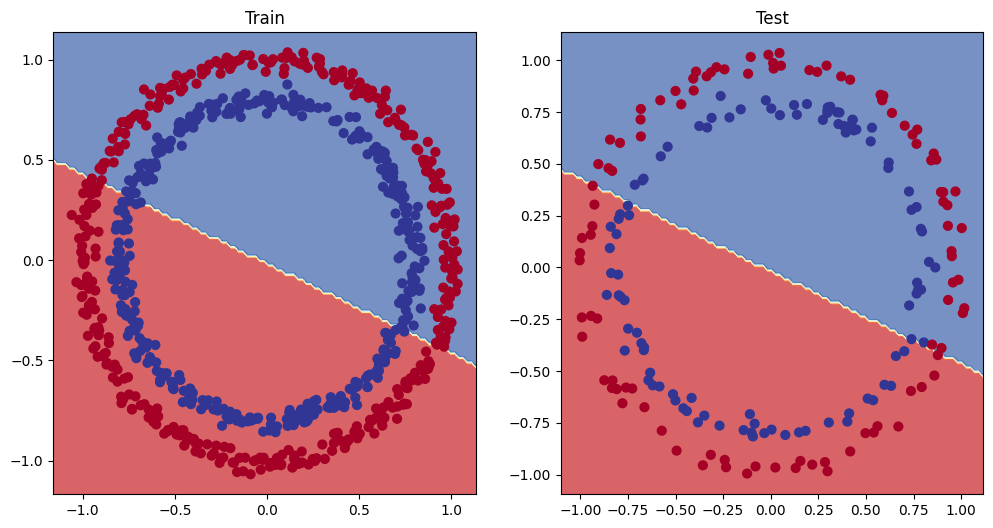

In [44]:
# Plot the decision boundary
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [45]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim = 1)
y_regression = weight * X_regression + bias

#Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [46]:
# Create a train/test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

#Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

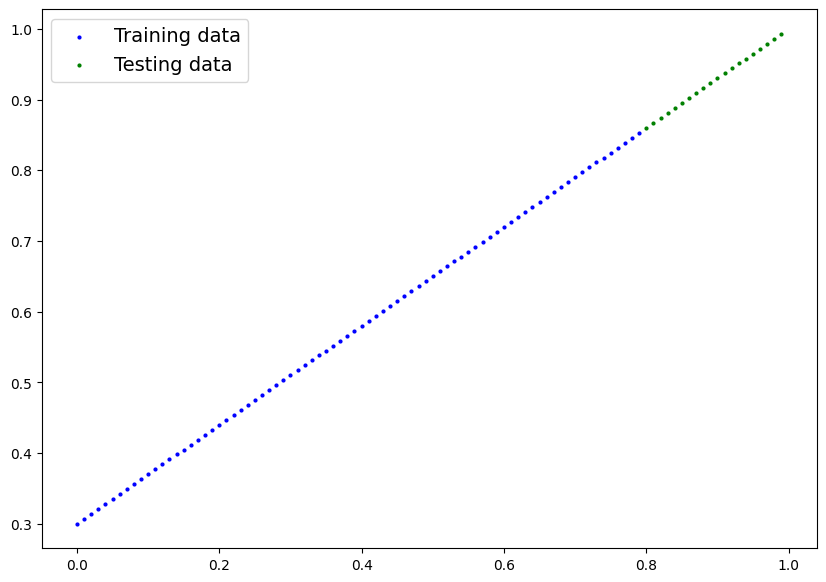

In [47]:
plot_predictions(train_data=X_train_regression,\
                 train_labels = y_train_regression,\
                 test_data = X_test_regression,\
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [48]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
    ).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [50]:
# Loss and optimizer (L1 loss for regression)
loss_fn = nn.L1Loss() # MAE loss for regression data
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)

In [51]:
#Lets setup the seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Put the data into the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Lets setup epochs
epochs = 1000

# For epoch in a range
for epoch in range(epochs + 1):
  ### Train: Set the model.train()
  model_2.train()

  # 1. Do the forward pass
  y_pred = model_2(X_train_regression)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train_regression)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Do the forward pass
    test_pred = model_2(X_test_regression)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)
    # Print out whats hapenning
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986| Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858| Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533| Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137| Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964| Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940| Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903| Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878| Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840| Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798| Test Loss: 0.00360
Epoch: 1000 | Loss: 0.01782| Test Loss: 0.00333


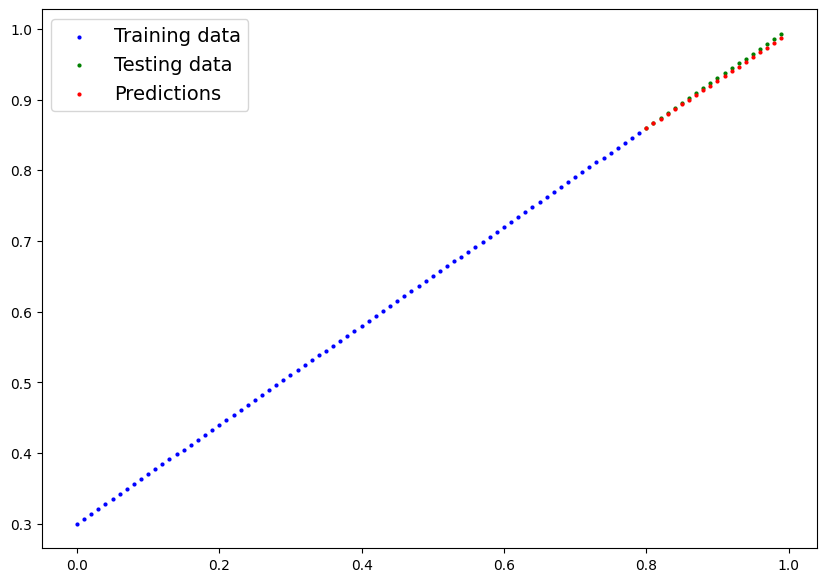

In [52]:
# Turn on evaluation mode
model_2.eval()

#Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

#Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),\
                 train_labels = y_train_regression.cpu(),\
                 test_data = X_test_regression.cpu(),\
                 test_labels=y_test_regression.cpu(),\
                 predictions = y_preds.cpu())

## 6. The missing piece: non-linearity

""What patters could you draw if you were an infinite amount of straight and non-straight lines?"

Or on ML terms, an infinite (but really is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

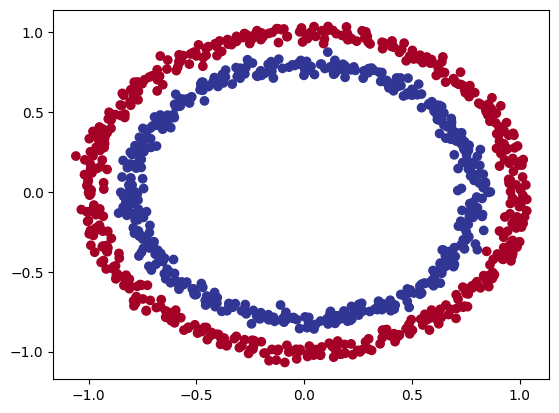

In [53]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdYlBu)

In [54]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 6.2 Building a model with non-linearity

* Linear = straight linear.
* Non-linear = non-straight line.

In [55]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features =10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [56]:
# Setup an optimizer and loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)

In [57]:
# Lets setup trianing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Setup the number of epochs
epochs = 10000

# For epoch in a range
for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probs -> predicted labels

  # 2 Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_true = y_train,\
                          y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing ####
  model_3.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate the test loss and test accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,\
                           y_pred = test_pred)

    # Print out whats happening, every 100 epoch
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}| Train Acc: {train_acc:.2f}%| Test Loss: {test_loss:.5f}| Test Acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.69295| Train Acc: 50.00%| Test Loss: 0.69319| Test Acc: 50.00
Epoch: 100 | Loss: 0.69115| Train Acc: 52.88%| Test Loss: 0.69102| Test Acc: 52.50
Epoch: 200 | Loss: 0.68977| Train Acc: 53.37%| Test Loss: 0.68940| Test Acc: 55.00
Epoch: 300 | Loss: 0.68795| Train Acc: 53.00%| Test Loss: 0.68723| Test Acc: 56.00
Epoch: 400 | Loss: 0.68517| Train Acc: 52.75%| Test Loss: 0.68411| Test Acc: 56.50
Epoch: 500 | Loss: 0.68102| Train Acc: 52.75%| Test Loss: 0.67941| Test Acc: 56.50
Epoch: 600 | Loss: 0.67515| Train Acc: 54.50%| Test Loss: 0.67285| Test Acc: 56.00
Epoch: 700 | Loss: 0.66659| Train Acc: 58.38%| Test Loss: 0.66322| Test Acc: 59.00
Epoch: 800 | Loss: 0.65160| Train Acc: 64.00%| Test Loss: 0.64757| Test Acc: 67.50
Epoch: 900 | Loss: 0.62362| Train Acc: 74.00%| Test Loss: 0.62145| Test Acc: 79.00
Epoch: 1000 | Loss: 0.56818| Train Acc: 87.75%| Test Loss: 0.57378| Test Acc: 86.50
Epoch: 1100 | Loss: 0.48153| Train Acc: 93.50%| Test Loss: 0.49935| Test Acc: 90.50
Epoc

### 6.4 Evaluation a model trained with non-linear activation functions

In [58]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

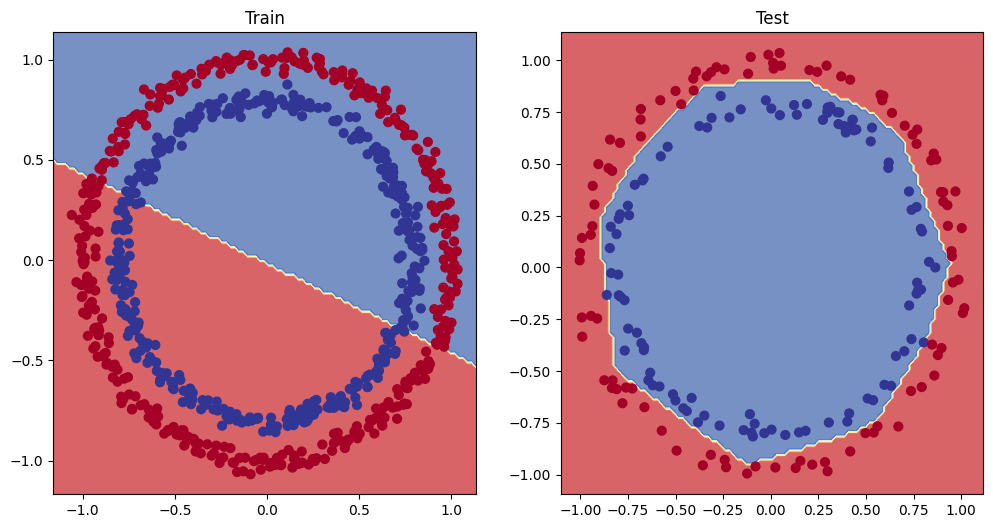

In [59]:
# Plot the decision boundary
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # Model_1: Only linear model
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # Model_3: Non_linear model

## 7. Replicating non-linear activation functions

Neural networks, rather than telling the model to learn, give it the tools to discover patterns in data and it tried to figure out patterns on its own.

And these tools are linear & non-linear functions

In [60]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

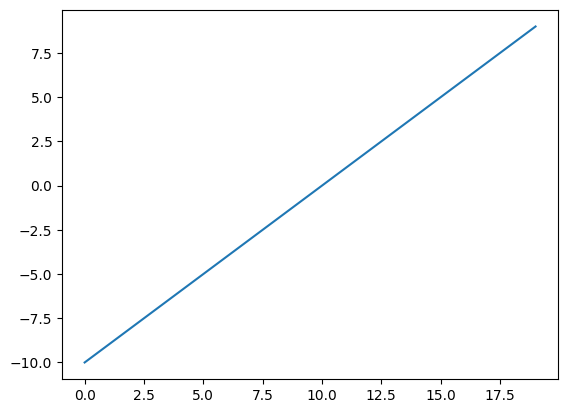

In [61]:
# Visualize data
plt.plot(A)

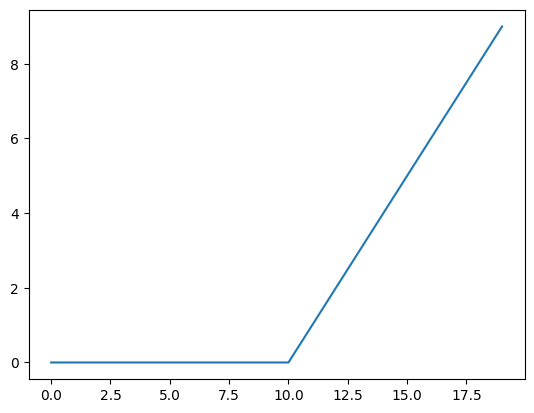

In [62]:
plt.plot(torch.relu(A))

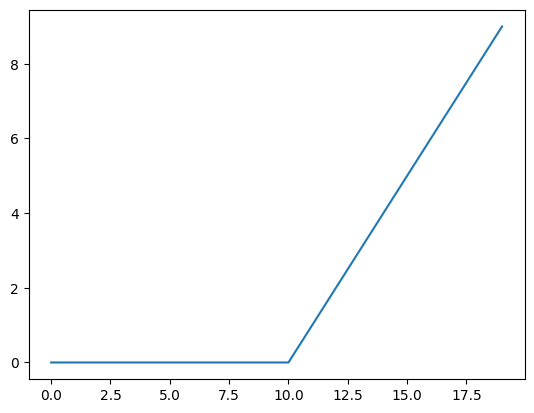

In [63]:
def my_relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # Inputs must be tensors

plt.plot(my_relu(A))

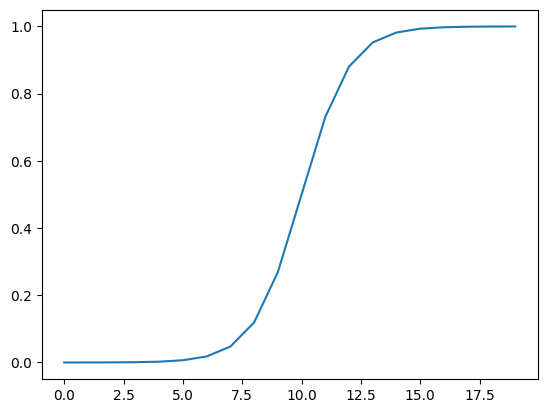

In [64]:
def my_sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

plt.plot(my_sigmoid(A))

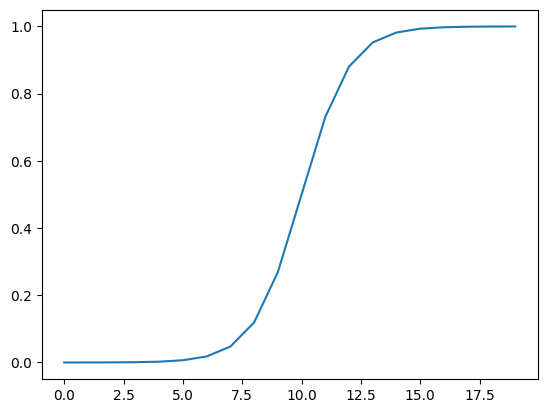

In [65]:
plt.plot(torch.sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not spam, fraud or not fraud).
* Multi-class classification = mote then one thing or another (cat vs dog vs chicken).

### 8.1 Creating a toy multi-class dataset

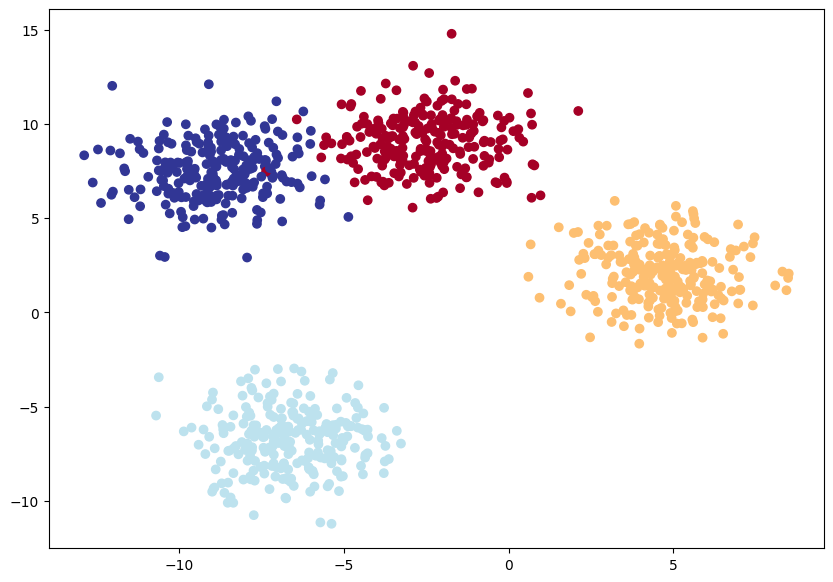

In [66]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

#Set the hyperparameters for the data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, # give the clusters a little shake up
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)\

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size = 0.2,
    random_state = RANDOM_SEED
)

# 4. Plot data (Visualize, visualize, visualize)
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [67]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [68]:
from torch import nn

# Build a multi classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    '''
    Initalizes multi-class classification model

    Args:
      input_features (int): Number of input features to the model.
      output_features (int): Number of output features (number of output classes).
      hidden_units (int): Number of hidden units between layers, default 8.

    Returns:

    Example:
    '''
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features = 2, output_features = 4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [69]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

### 8.3 Create a loss function and an optimizer for our multiclass model

In [70]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_4.parameters(),
                          lr = 0.1) # Learning rate is a hyper parameter you can change

### 8.4 Getting probabilities for a multi-class PyTorch Model:

In order to evaluate abnd train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model)-> Pred Probs (use `torch.softmax()`) -> Pred labels (take the argmax of the prediction probabilities)

In [71]:
# Lets get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [72]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

In [73]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [74]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:100]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0])

In [75]:
y_blob_test[:100]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2.])

### 8.5 Creating a training and testing loop for multi-class PyTorch model

In [76]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set the number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through the data
for epoch in range(epochs + 1):
  ### Training
  model_4.train()
  y_logits = model_4(X_blob_train).squeeze()
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor))
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test).squeeze()
    y_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
    test_loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor))

    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = y_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}| Train Acc: {acc:.2f}%| Test Loss: {test_loss:.5f}| Test Acc: {test_acc:.2f}")


Epoch: 0 | Loss: 1.15883| Train Acc: 40.38%| Test Loss: 1.07554| Test Acc: 48.00
Epoch: 10 | Loss: 0.64476| Train Acc: 96.75%| Test Loss: 0.66069| Test Acc: 97.50
Epoch: 20 | Loss: 0.42535| Train Acc: 98.50%| Test Loss: 0.43074| Test Acc: 100.00
Epoch: 30 | Loss: 0.25294| Train Acc: 99.12%| Test Loss: 0.24508| Test Acc: 99.50
Epoch: 40 | Loss: 0.11232| Train Acc: 99.25%| Test Loss: 0.10229| Test Acc: 99.50
Epoch: 50 | Loss: 0.06627| Train Acc: 99.25%| Test Loss: 0.05848| Test Acc: 99.50
Epoch: 60 | Loss: 0.05068| Train Acc: 99.25%| Test Loss: 0.04293| Test Acc: 99.50
Epoch: 70 | Loss: 0.04300| Train Acc: 99.25%| Test Loss: 0.03491| Test Acc: 99.50
Epoch: 80 | Loss: 0.03836| Train Acc: 99.25%| Test Loss: 0.02988| Test Acc: 99.50
Epoch: 90 | Loss: 0.03525| Train Acc: 99.25%| Test Loss: 0.02663| Test Acc: 99.50
Epoch: 100 | Loss: 0.03312| Train Acc: 99.25%| Test Loss: 0.02433| Test Acc: 99.50


### 8.6 Making and evalating predictions with a PyTorch multi-class model

In [77]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

# View the logits
y_logits[:10]

tensor([[-0.6257,  6.0063, -7.6488, -8.4666],
        [-2.1813, -6.3889, -3.7303,  3.1376],
        [-3.4241, -3.9088,  3.1701, -2.6211],
        [-1.1539,  4.2110, -3.8565, -4.8926],
        [ 3.7713, -1.3379, -9.1623, -6.9665],
        [-2.8284, -7.5936, -4.3072,  3.8118],
        [-3.0427, -3.3442,  2.8070, -2.1454],
        [ 3.3902, -4.0445, -6.9149, -3.5610],
        [-4.3793, -5.0066,  3.8291, -3.3930],
        [ 3.5159, -3.0320, -7.5575, -4.7203]])

In [78]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10]

tensor([[1.3158e-03, 9.9868e-01, 1.1725e-06, 5.1754e-07],
        [4.8691e-03, 7.2458e-05, 1.0344e-03, 9.9402e-01],
        [1.3611e-03, 8.3833e-04, 9.9476e-01, 3.0383e-03],
        [4.6540e-03, 9.9492e-01, 3.1196e-04, 1.1070e-04],
        [9.9397e-01, 6.0044e-03, 2.4010e-06, 2.1578e-05],
        [1.3046e-03, 1.1117e-05, 2.9733e-04, 9.9839e-01],
        [2.8462e-03, 2.1055e-03, 9.8807e-01, 6.9819e-03],
        [9.9842e-01, 5.8947e-04, 3.3409e-05, 9.5600e-04],
        [2.7205e-04, 1.4528e-04, 9.9885e-01, 7.2945e-04],
        [9.9829e-01, 1.4306e-03, 1.5493e-05, 2.6443e-04]])

In [79]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
print(y_preds[:10])
print(y_blob_test[:10])

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])


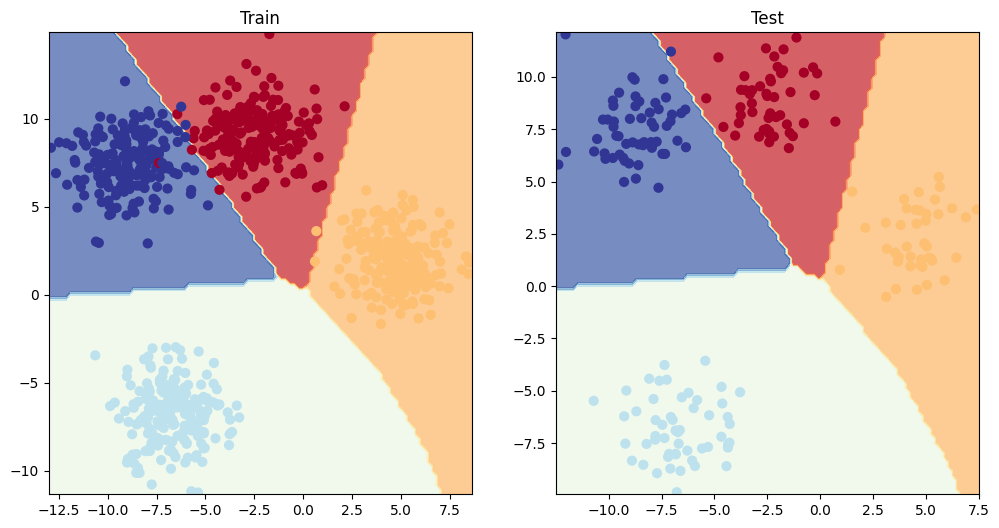

In [80]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

If you want access to a lot of PyTorcg metrics, see TorchMetrics: https://lightning.ai/docs/torchmetrics/stable/



In [81]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [84]:
from torchmetrics import Accuracy

#Setup metric
torchmetric_accuracy = Accuracy(task = "multiclass", num_classes = 4).to(device)

#Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950)